In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data_path = "/home/clairegayral/Documents/openclassroom/data/P3/"
res_path = "/home/clairegayral/Documents/openclassroom/res/P3/"

## my .py : 
import preprocess
import missing_values_treatment
import univariate_analysis

from sklearn import model_selection 
from sklearn import preprocessing
from sklearn import neighbors
from sklearn.impute import KNNImputer


In [2]:
df_2015 = pd.read_csv(data_path+"2015-building-energy-benchmarking.csv", 
                          low_memory=False)#, index_col=0)
df_2016 = pd.read_csv(data_path+"2016-building-energy-benchmarking.csv", 
                          low_memory=False)#, index_col=0)

print("In 2015 data :", df_2015.shape[0],
      " buildings and ", df_2015.shape[1],"variables")
print("Total NaNs = ", df_2015.isna().sum().sum(), 
      "(that is ",np.round(100*df_2015.isna().sum().sum()/(
        df_2015.shape[0]*df_2015.shape[1]),2), "%)")

float_var = df_2015.loc[:,df_2015.dtypes==float].columns
data = df_2015.loc[:,np.append(np.array(float_var),"OSEBuildingID")]

In 2015 data : 3340  buildings and  47 variables
Total NaNs =  26512 (that is  16.89 %)


## Prétraitement 
Les types semblent corrects (vérifiés avec df.dtypes). 

##### Gestion des doublons :

In [3]:
data = df_2015.loc[:,np.append(np.array(float_var),"OSEBuildingID")]
dict_duplicates = preprocess.get_index_merge_duplicates(data, float_var, 1.15)
print(dict_duplicates)

{}


#####  Suppression colonnes vides :

In [4]:
##
## drop empty columns
##
data = df_2015.loc[:,float_var].set_index(df_2015["OSEBuildingID"])

nan_repartition = data.isna().sum(axis=0)
# nan_threshold = nan_repartition.mean()
nan_threshold = nan_repartition.quantile(0.95)
data = missing_values_treatment.preprocess_drop_col_nan(data, nan_threshold)

print("I drop variables with less than", 
      data.shape[0]-np.floor(nan_threshold),
      "values")
print("That is more than", 
      np.floor(nan_threshold),
      "missing values")
print("I have dropped", len(float_var)- data.shape[1] + 2,
      "variables :",
      float_var[[var not in data.columns for var in float_var]])

I drop variables with less than 258.0 values
That is more than 3082.0 missing values
I have dropped 4 variables : Index(['2010 Census Tracts', 'City Council Districts'], dtype='object')


In [5]:
float_var = data.columns[[var not in ["ENERGYSTARScore", "OSEBuildingID"] for var in data.columns]]
X = data[float_var]
y = data["ENERGYSTARScore"]


##### Inférence valeurs manquantes : 

MSE = 131.642 (+/-23.211) for {'n_neighbors': 1}
MSE = 116.114 (+/-13.146) for {'n_neighbors': 2}
MSE = 111.882 (+/-10.362) for {'n_neighbors': 3}
MSE = 110.496 (+/-10.746) for {'n_neighbors': 4}
MSE = 110.178 (+/-11.167) for {'n_neighbors': 5}
MSE = 110.570 (+/-11.347) for {'n_neighbors': 6}
MSE = 110.877 (+/-11.766) for {'n_neighbors': 7}
MSE = 111.173 (+/-11.955) for {'n_neighbors': 8}
MSE = 111.373 (+/-12.669) for {'n_neighbors': 9}
MSE = 111.522 (+/-13.120) for {'n_neighbors': 10}
MSE = 111.627 (+/-13.281) for {'n_neighbors': 11}
MSE = 111.866 (+/-13.065) for {'n_neighbors': 12}
MSE = 112.016 (+/-13.351) for {'n_neighbors': 13}
MSE = 112.140 (+/-13.771) for {'n_neighbors': 14}
MSE = 112.218 (+/-14.038) for {'n_neighbors': 15}
MSE = 112.370 (+/-14.009) for {'n_neighbors': 16}
MSE = 112.547 (+/-14.098) for {'n_neighbors': 17}
MSE = 112.621 (+/-13.980) for {'n_neighbors': 18}
MSE = 112.725 (+/-14.100) for {'n_neighbors': 19}
MSE = 112.934 (+/-14.236) for {'n_neighbors': 20}
MSE = 113

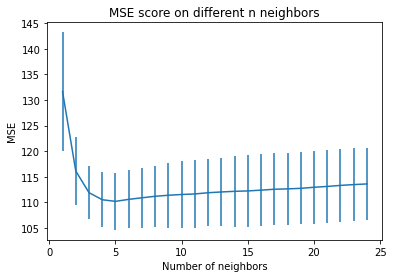

In [6]:
##
## Standardize X : 
##

standardizer = preprocessing.StandardScaler().fit(X)
X_std = standardizer.transform(X)
X_std = pd.DataFrame(X_std, columns= X.columns, index = X.index)

# ##
# ## Set the best number of neighbors
# ##

my_meth = KNNImputer
param_grid = {"n_neighbors" : np.arange(1,25,1)}
cv = 3

# res = missing_values_treatment.launch_my_pseudo_CV(X_std,my_meth,param_grid, cv = cv)
# # Save dictionnary of results : 
# import pickle
# with open(res_path+"set_n_KNN_impute"+".pkl", "wb") as f :
#     pickle.dump(res, f, pickle.HIGHEST_PROTOCOL)

import pickle
with open(res_path+"set_n_KNN_impute"+".pkl", "rb") as f :
        res = pickle.load(f)

fig_name = "set_n_KNN_impute.jpg"
missing_values_treatment.plot_MSE_scores_KNN_impute(res, param_grid, fig_name)

In [7]:
## Impute missing values :
imputer = KNNImputer(n_neighbors=4)
pred_std = imputer.fit_transform(X_std)
pred_std = pd.DataFrame(pred_std, index = X.index, columns = X.columns)

## Inverse-standardize : 
# pred_std = pd.read_csv(res_path+"dataframe_std_KNN_impute.csv",index_col=0)
pred = standardizer.inverse_transform(pred_std)
pred = pd.DataFrame(pred, index = X.index, columns = X.columns)


##### Retrait des bâtiments sans le score : 

In [8]:
index_to_drop = data[data["ENERGYSTARScore"].isna().values].index
data = data.drop(index_to_drop,axis=0)

X = data[float_var]
X_pred = pred.drop(index_to_drop,axis=0)
y = data["ENERGYSTARScore"]

## Etude des variables descriptives numériques

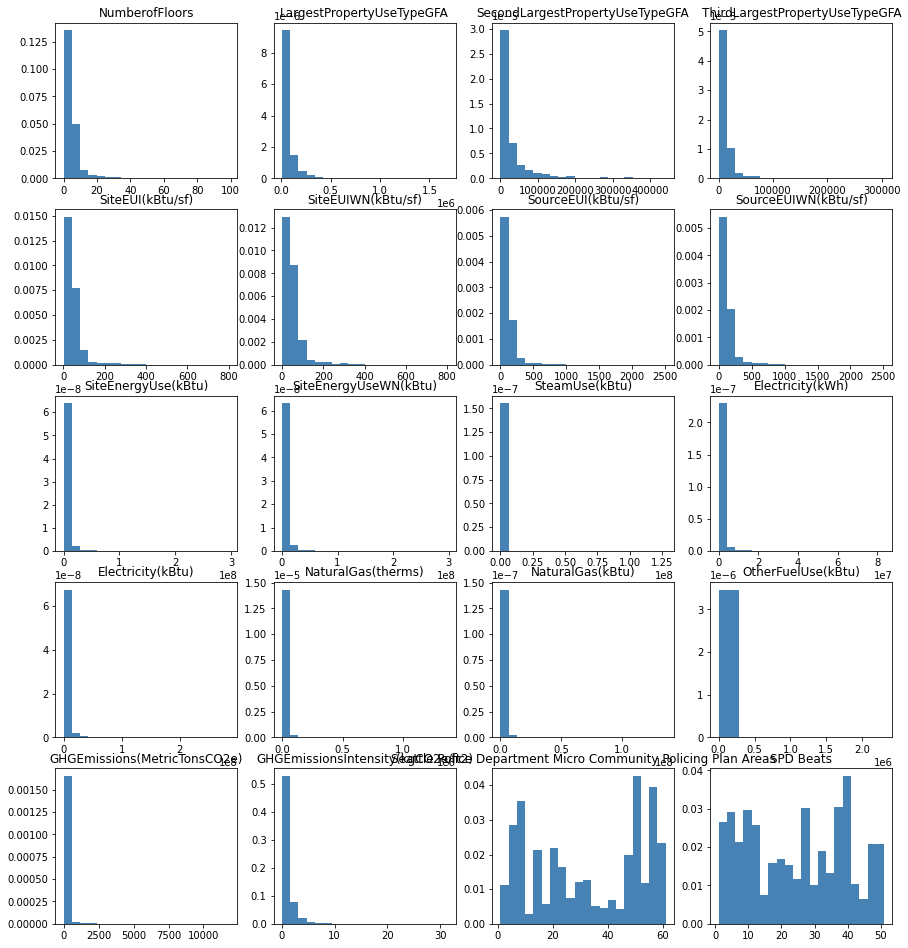

In [16]:
nb_line_plot = int(np.floor(len(float_var)/4)+1)
fig = plt.figure(figsize=(15, 20))

fig_count = 1
for var in float_var :#data.columns.intersection(list_of_nutri_facts):
    ax = fig.add_subplot(nb_line_plot,4, fig_count)
    nb_bins = min(20, len(np.unique(data[var].dropna().values)))
    ax.hist(data[var], bins = nb_bins, color='steelblue', density=True, edgecolor='none')
    ax.set_title(var)
    fig_count += 1
plt.show()

In [15]:
data["Seattle Police Department Micro Community Policing Plan Areas"]
data["SPD Beats"]

OSEBuildingID
1        31.0
2        31.0
3        31.0
5        31.0
8        31.0
         ... 
50049    16.0
50055    38.0
50057     7.0
50058    48.0
50059    48.0
Name: SPD Beats, Length: 2560, dtype: float64

## Etude de la variable de réponse 

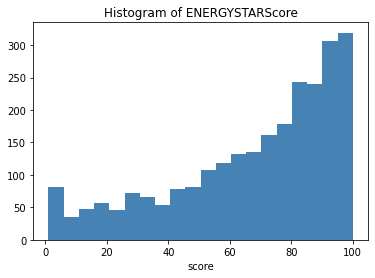

count    2560.000000
mean       67.894141
std        27.154057
min         1.000000
25%        51.750000
50%        76.000000
75%        90.000000
max       100.000000
Name: ENERGYSTARScore, dtype: float64

In [10]:
import univariate_analysis

univariate_analysis.plot_hist_y(y)
    
y.describe()

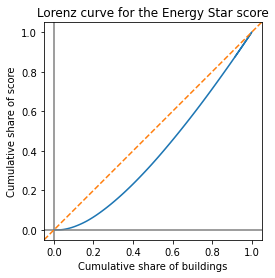

gini = 0.22380585297213407
AUC = 0.38809707351393297


In [11]:
univariate_analysis.plot_lorenz_curve(y)